#ResNet50 Model Experiments
In this notebook, ResNet50 model will be experimented to find out the best model for GTSRB dataset.

The whole notebook will be divided into 6 parts.

- **Part 1:** **Dataset** - Dataset will be loaded and preprocessed in this part.
- **Part 2:** **Define functions** - Training function, Accuracy and loss curve function and evaluate function will be defined here.
- **Part 3:** **Fine-Tuning** - Different layer combinations of the pre-trained model will be experimented.
- **Part 4:** **Hyperparameter tuning**
  - 4.1 Learning Rate (LR) Experiments
  - 4.2 Batch Size Experiments
- **Part 5: Train Best model for more epochs**
- **Part 6: Train best model on oversampled dataset**

#Mount Google Drive and import libraries

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

Mounted at /content/drive


In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import random

# Set the seed
random.seed(42)

#Part 1: Dataset

##Load training data

In [ ]:
# Define paths to dataset
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size
IMG_SIZE = 32  # Resize images
num_classes = 43

# Define function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

## Print total number of images in the training dataset

In [ ]:
# Store the images and labels in two new folders
train_images, train_labels = images, labels

# Print dataset shape
print(f'train_images shape: {train_images.shape}')
print(f'train_labels shape: {train_labels.shape}')

train_images shape: (39209, 32, 32, 3)
train_labels shape: (39209, 43)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 80% of the dataset will be used for training, and the remaining 20% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [ ]:
train_images, train_labels = images, labels

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


## Load test data

In [ ]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

Skipping non-image file: GT-final_test.test.csv


##Total Number of images in the test data

In [ ]:
# Print test dataset shape
print(f'X_test shape: {X_test.shape}')

X_test shape: (12630, 32, 32, 3)


##Load ground truth

In [ ]:
# Load the ground truth file (downloaded separately)
ground_truth = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

#Part 2: Define Functions

##Compile and train model

In [ ]:
# define a function to train the model
def train_model(model, lr, BATCH_SIZE, EPOCHS):
    """
    This function will train the model.
    Parameters:
        model: the model that will be trained
        lr: learning rate
        BATCH_SIZE: batch size
        EPOCHS: number of epochs
    """
    # Initialize EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        callbacks=[early_stopping]
    )

    return history

##Accuracy and loss curve

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# write a function to visualize curves
def visualize_training_curves(history):

    """
    This function will plot the accuracy and loss curve of the trained model.
    parameter:
        history: It contains taining history of the model
    """

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # set epochs to start from 1
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    axes[0].plot(epochs, history.history['accuracy'], label='train_accuracy', color="blue")
    axes[0].plot(epochs, history.history['val_accuracy'], label='val_accuracy', color="orange")
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylim(0, 1)
    axes[0].legend(loc='lower right')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    # Plot loss
    axes[1].plot(epochs, history.history['loss'], label='train_loss', color="green")
    axes[1].plot(epochs, history.history['val_loss'], label='val_loss', color="red")
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    plt.tight_layout()
    plt.show()

##Evaluate model on test data

In [ ]:
# Write a function to evaluate the trained model
def evaluate_model(model, X_test, ground_truth_df):

    """
    This function will evaluate the trained model on test data.
    Parameters:
        model: The trained model
        X_test: contains the test dataset
        ground_truth: contains the true class of the test images
    """

    # Predict class probabilities
    predictions = model.predict(X_test)

    # Get the class index with the highest probability
    predicted_classes = np.argmax(predictions, axis=1)

    # Save predicted classes and the image file names to a dataframe
    predictions_df = pd.DataFrame({
        'Filename': test_img_names,
        'Predicted Class': predicted_classes
    })

    # Ensure the filenames are sorted in ascending order in the result file
    predictions_df = predictions_df.sort_values(by='Filename')

    # Merge both dataframes on the 'Filename' column
    merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

    # Calculate accuracy by comparing predicted classes with actual classes
    accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

    print(f"Learning rate: {lr},\nBatch Size: {BATCH_SIZE},")

    # get the lowest validation loss epoch
    epoch_with_lowest_val_loss = np.argmin(history.history['val_loss'])

    # get validation accuracy of that epoch
    val_accuracy = history.history['val_accuracy'][epoch_with_lowest_val_loss]

    # print validation accuracy and test accuracy
    print(f"Validation accuracy: {val_accuracy*100:.2f}%,\nTest Accuracy: {accuracy * 100:.2f}%.")

#Part 3: Fine-Tuning (Layer Experiments)

##Load Model:

###Trainable base model layers: 0, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 1, 1, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,667,051 (94.10 MB)

 Trainable params: 1,075,243 (4.10 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

##Compile and train the model

Trainable base model layers: 0
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.2646 - loss: 2.7432 - val_accuracy: 0.4765 - val_loss: 1.8188
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.4819 - loss: 1.7949 - val_accuracy: 0.5445 - val_loss: 1.5365
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5482 - loss: 1.5442 - val_accuracy: 0.6000 - val_loss: 1.3464
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.5902 - loss: 1.3777 - val_accuracy: 0.6566 - val_loss: 1.2088
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6267 - loss: 1.2581 - val_accuracy: 0.6625 - val_loss: 1.1200


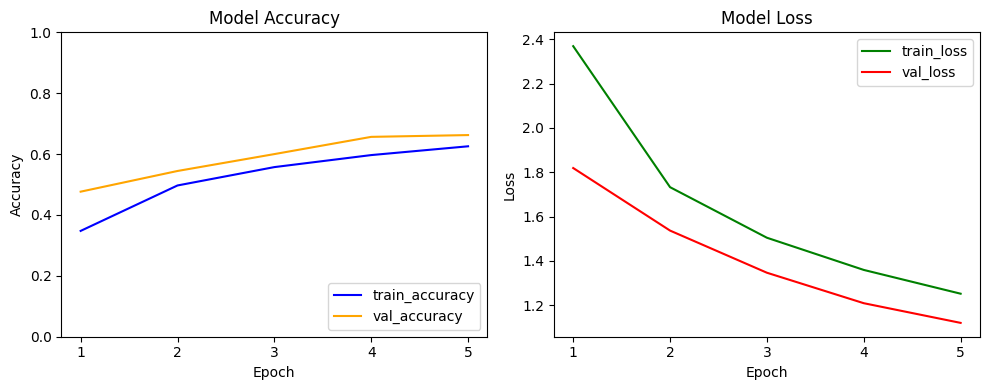

395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 66.25%,
Test Accuracy: 50.10%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: 0\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: Top 32, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze some layers of base model
for layer in base_model.layers[:143]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 1, 1, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,667,051 (94.10 MB)

 Trainable params: 16,051,243 (61.23 MB)

 Non-trainable params: 8,615,808 (32.87 MB)

##Compile and train the model

Trainable base model layers: Top 32
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.2329 - loss: 2.8200 - val_accuracy: 0.0879 - val_loss: 3.7429
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.4620 - loss: 1.7686 - val_accuracy: 0.1125 - val_loss: 5.0497
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5521 - loss: 1.4471 - val_accuracy: 0.0685 - val_loss: 4.8054
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6218 - loss: 1.2468 - val_accuracy: 0.1502 - val_loss: 5.1115
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6588 - loss: 1.0978 - val_accuracy: 0.0105 - val_loss: 7.6228


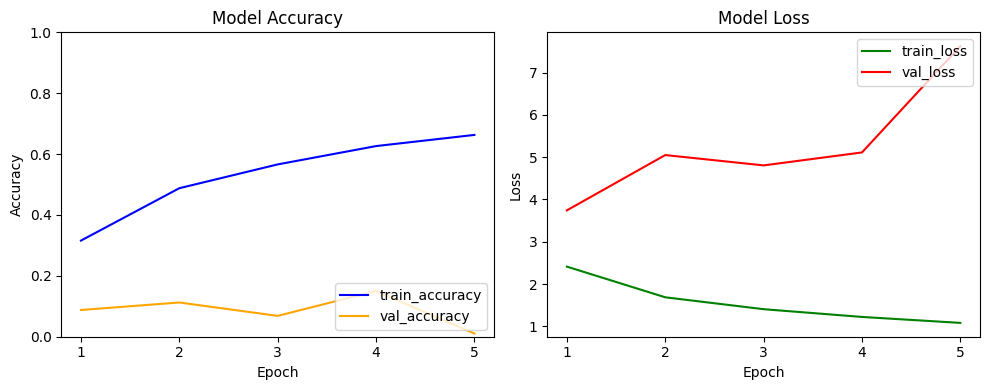

395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 8.79%,
Test Accuracy: 8.45%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Top 32\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: Top 94, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze some layers of base model
for layer in base_model.layers[:81]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 1, 1, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,667,051 (94.10 MB)

 Trainable params: 23,159,851 (88.35 MB)

 Non-trainable params: 1,507,200 (5.75 MB)

##Compile and train the model

Trainable base model layers: Top 94
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 73s 43ms/step - accuracy: 0.2131 - loss: 2.8791 - val_accuracy: 0.0982 - val_loss: 3.6761
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5929 - loss: 1.2835 - val_accuracy: 0.0576 - val_loss: 4.5445
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.6976 - loss: 0.9629 - val_accuracy: 0.0939 - val_loss: 4.8233
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.7575 - loss: 0.7441 - val_accuracy: 0.0574 - val_loss: 4.5087
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.7518 - loss: 0.7698 - val_accuracy: 0.0802 - val_loss: 5.5198


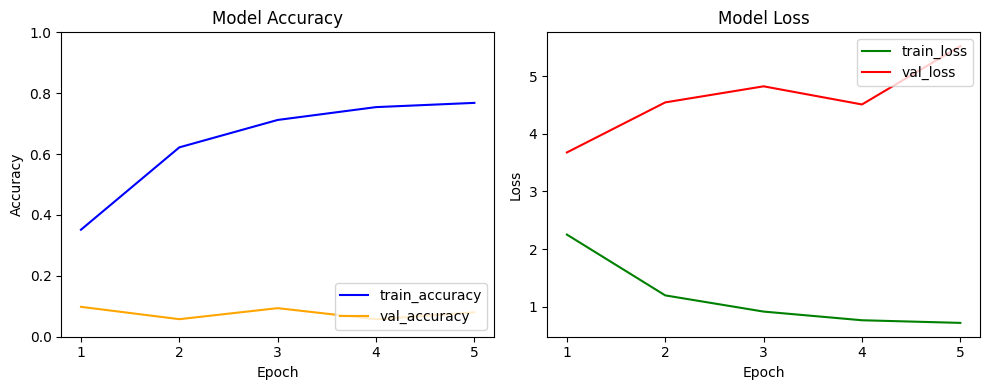

395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 9.82%,
Test Accuracy: 9.33%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Top 94\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: Top 150, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze some layers of base model
for layer in base_model.layers[:25]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 1, 1, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,667,051 (94.10 MB)

 Trainable params: 24,470,955 (93.35 MB)

 Non-trainable params: 196,096 (766.00 KB)

##Compile and train the model

Trainable base model layers: Top 150
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 96s 52ms/step - accuracy: 0.3013 - loss: 2.4629 - val_accuracy: 0.3730 - val_loss: 2.9054
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.6180 - loss: 1.2190 - val_accuracy: 0.6770 - val_loss: 1.0525
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.7467 - loss: 0.8008 - val_accuracy: 0.7175 - val_loss: 0.9695
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.8136 - loss: 0.5979 - val_accuracy: 0.6502 - val_loss: 1.4175
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.8468 - loss: 0.4730 - val_accuracy: 0.4542 - val_loss: 2.5405


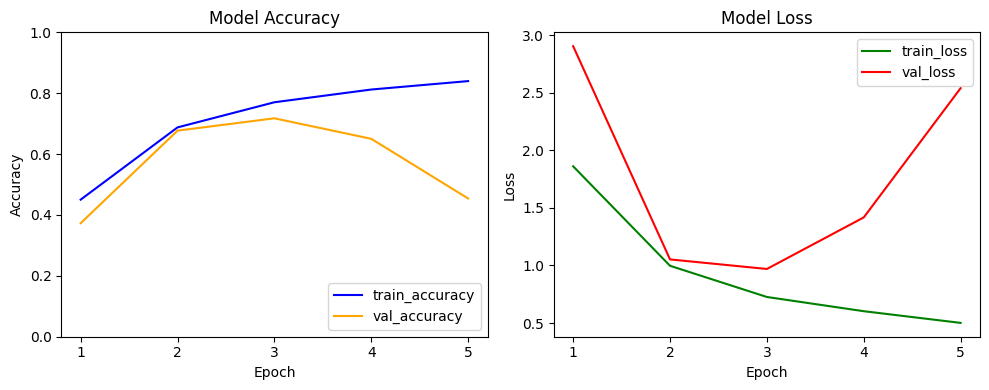

395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 71.75%,
Test Accuracy: 68.15%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Top 150\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: All, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Unfreeze all layers of base model
for layer in base_model.layers:
    layer.trainable = True

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,667,051 (94.10 MB)

 Trainable params: 24,609,835 (93.88 MB)

 Non-trainable params: 57,216 (223.50 KB)

##Compile and train the model

Trainable base model layers: All
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 121s 67ms/step - accuracy: 0.5972 - loss: 1.4041 - val_accuracy: 0.0645 - val_loss: 5.1182
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 86s 35ms/step - accuracy: 0.8544 - loss: 0.4925 - val_accuracy: 0.8898 - val_loss: 0.3863
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.9355 - loss: 0.2181 - val_accuracy: 0.9283 - val_loss: 0.2165
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9617 - loss: 0.1373 - val_accuracy: 0.9546 - val_loss: 0.1581
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9607 - loss: 0.1427 - val_accuracy: 0.9207 - val_loss: 0.2873


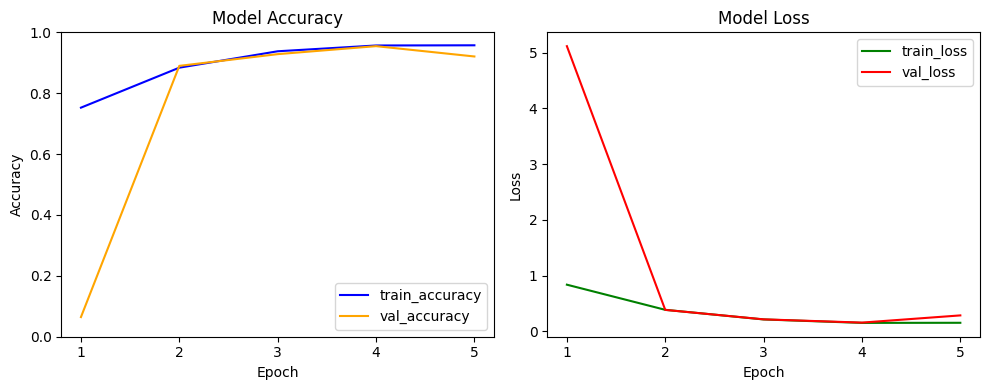

395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 95.46%,
Test Accuracy: 90.85%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: All\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the ResNet50 model: Train only first 1 convolutional layer with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('pool1_pool').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<InputLayer name=input_layer, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<BatchNormalization name=batch_normalization, built=True>
<Flatten name=flatten, built=True>
<Dense name=dense, built=True>
<Dense name=dense_1, built=True>


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_pad (ZeroPadding2D)            │ (None, 38, 38, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_conv (Conv2D)                  │ (None, 16, 16, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 16, 16, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (Activation)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_pad (ZeroPadding2D)            │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_pool (MaxPooling2D)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,129,707 (8.12 MB)

 Trainable params: 2,129,451 (8.12 MB)

 Non-trainable params: 256 (1.00 KB)

###Compile and train the model

Train only first 1 convolutional layer with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7447 - loss: 0.9799 - val_accuracy: 0.8680 - val_loss: 0.4758
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9830 - loss: 0.0802 - val_accuracy: 0.9816 - val_loss: 0.0793
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9891 - loss: 0.0467 - val_accuracy: 0.9843 - val_loss: 0.0600
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9930 - loss: 0.0308 - val_accuracy: 0.9848 - val_loss: 0.0662
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9926 - loss: 0.0324 - val_accuracy: 0.9909 - val_loss: 0.0408


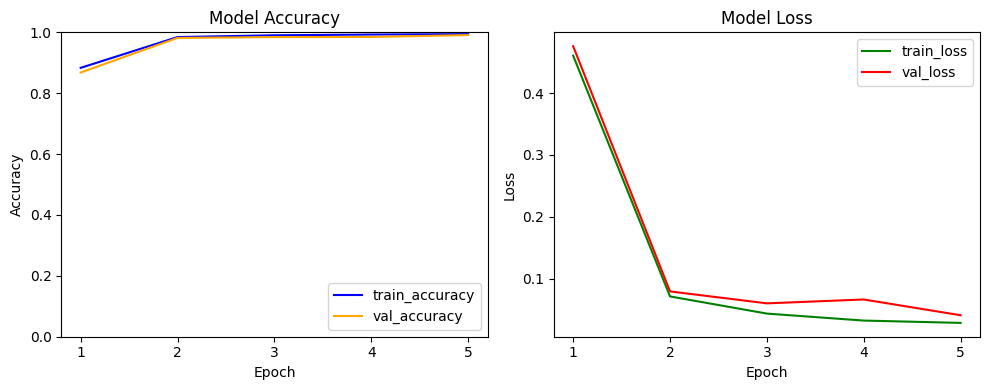

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.09%,
Test Accuracy: 91.94%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 1 convolutional layer with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the ResNet50 model: Train only first 5 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv2_block1_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_2, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<BatchNormalization name=batch_normalization_2, built=True>
<Flatten name=flatten_2, built=True>
<Dense nam

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 8,498,859 (32.42 MB)

 Trainable params: 8,496,939 (32.41 MB)

 Non-trainable params: 1,920 (7.50 KB)

###Compile and train the model

Train only first 5 convolutional layer with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8318 - loss: 0.6726 - val_accuracy: 0.9222 - val_loss: 0.3348
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9952 - loss: 0.0255 - val_accuracy: 0.9867 - val_loss: 0.0639
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9978 - loss: 0.0126 - val_accuracy: 0.9675 - val_loss: 0.1253
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9970 - loss: 0.0137 - val_accuracy: 0.9685 - val_loss: 0.1131
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9981 - loss: 0.0082 - val_accuracy: 0.9305 - val_loss: 0.2503


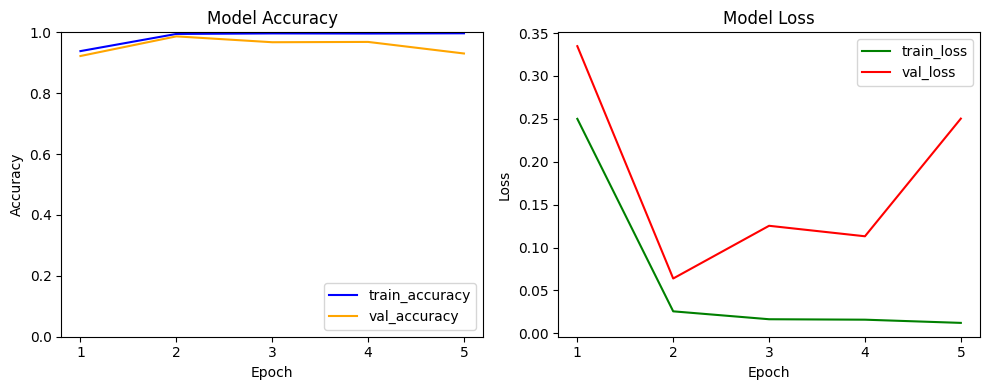

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.67%,
Test Accuracy: 93.62%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 5 convolutional layer with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the ResNet50 model: Train only first 8 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv2_block2_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_5, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Acti

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 8,570,411 (32.69 MB)

 Trainable params: 8,567,723 (32.68 MB)

 Non-trainable params: 2,688 (10.50 KB)

###Compile and train the model

Train only first 8 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8629 - loss: 0.5636 - val_accuracy: 0.9305 - val_loss: 0.2742
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9954 - loss: 0.0220 - val_accuracy: 0.9907 - val_loss: 0.0445
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9963 - loss: 0.0164 - val_accuracy: 0.9702 - val_loss: 0.1159
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9962 - loss: 0.0158 - val_accuracy: 0.9824 - val_loss: 0.0593
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9976 - loss: 0.0103 - val_accuracy: 0.9118 - val_loss: 0.2976


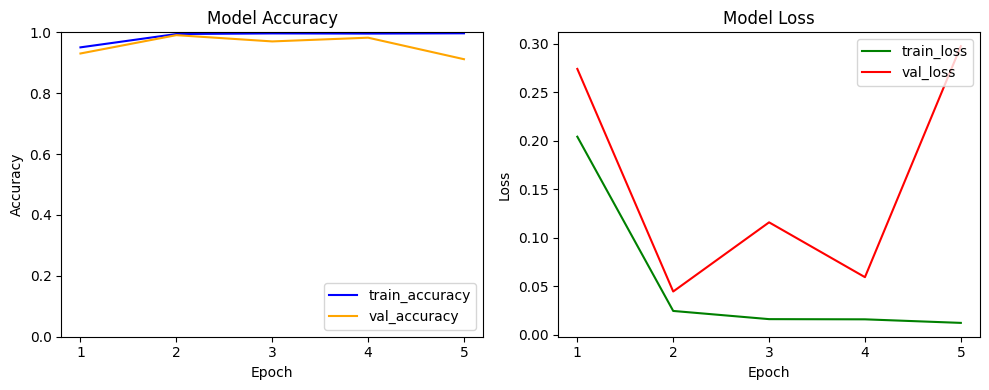

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.07%,
Test Accuracy: 94.97%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 8 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split ResNet50 model: Train only first 11 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv2_block3_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_7, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Acti

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 8,641,963 (32.97 MB)

 Trainable params: 8,638,507 (32.95 MB)

 Non-trainable params: 3,456 (13.50 KB)

###Compile and train the model

Train only first 11 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8733 - loss: 0.5036 - val_accuracy: 0.9055 - val_loss: 0.3119
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9950 - loss: 0.0232 - val_accuracy: 0.9792 - val_loss: 0.0770
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9959 - loss: 0.0179 - val_accuracy: 0.9611 - val_loss: 0.1269
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9976 - loss: 0.0106 - val_accuracy: 0.9640 - val_loss: 0.1173
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9961 - loss: 0.0148 - val_accuracy: 0.9786 - val_loss: 0.0779


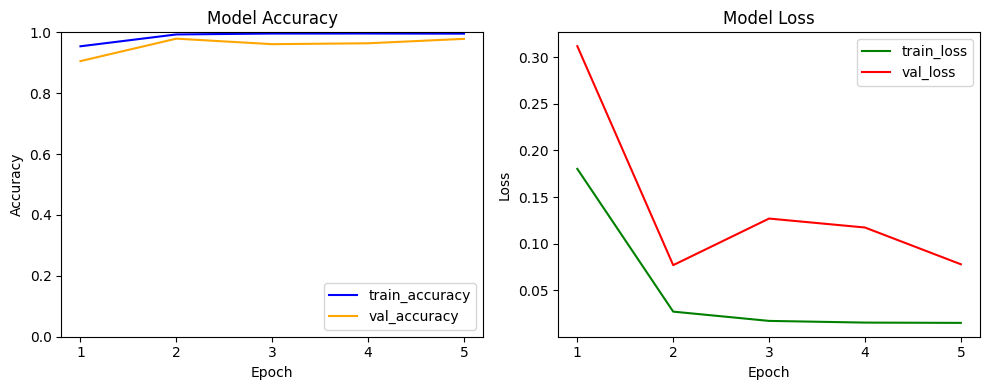

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 97.92%,
Test Accuracy: 94.01%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 11 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split ResNet50 model: Train only first 15 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv3_block1_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_9, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Acti

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 4,831,915 (18.43 MB)

 Trainable params: 4,825,387 (18.41 MB)

 Non-trainable params: 6,528 (25.50 KB)

###Compile and train the model

Train only first 15 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.8737 - loss: 0.4808 - val_accuracy: 0.9292 - val_loss: 0.2383
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9913 - loss: 0.0317 - val_accuracy: 0.9674 - val_loss: 0.1042
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9903 - loss: 0.0337 - val_accuracy: 0.9214 - val_loss: 0.3124
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9902 - loss: 0.0304 - val_accuracy: 0.9851 - val_loss: 0.0525
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9961 - loss: 0.0141 - val_accuracy: 0.9773 - val_loss: 0.0783


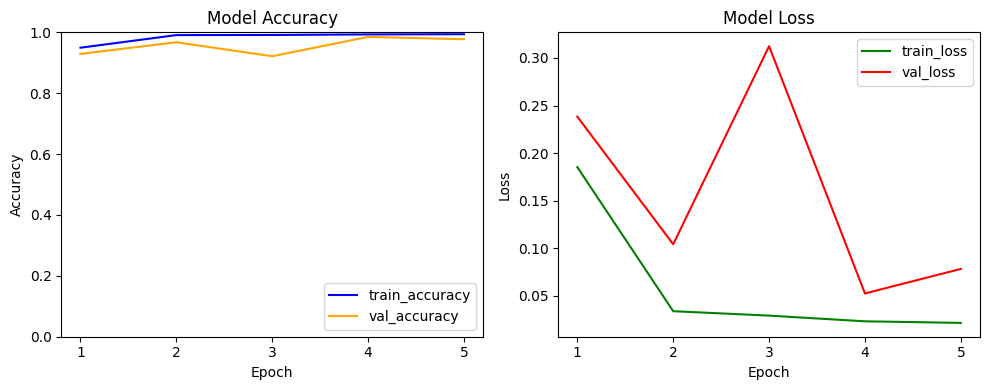

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.51%,
Test Accuracy: 94.00%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 15 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split ResNet50 model: Train only first 18 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv3_block2_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_11, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Act

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 5,114,283 (19.51 MB)

 Trainable params: 5,106,219 (19.48 MB)

 Non-trainable params: 8,064 (31.50 KB)

###Compile and train the model

Train only first 18 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8661 - loss: 0.4978 - val_accuracy: 0.9286 - val_loss: 0.2550
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9909 - loss: 0.0349 - val_accuracy: 0.9668 - val_loss: 0.1074
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9937 - loss: 0.0217 - val_accuracy: 0.9605 - val_loss: 0.1463
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9929 - loss: 0.0242 - val_accuracy: 0.9907 - val_loss: 0.0302
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9947 - loss: 0.0174 - val_accuracy: 0.9788 - val_loss: 0.0739


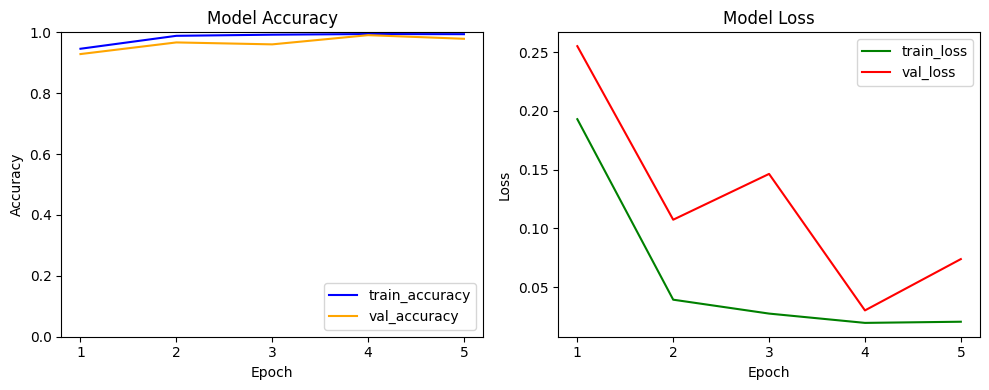

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.07%,
Test Accuracy: 93.84%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 18 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split ResNet50 model: Train only first 21 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv3_block3_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_13, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Act

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 5,396,651 (20.59 MB)

 Trainable params: 5,387,051 (20.55 MB)

 Non-trainable params: 9,600 (37.50 KB)

###Compile and train the model

Train only first 21 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.8737 - loss: 0.4600 - val_accuracy: 0.9376 - val_loss: 0.2088
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9873 - loss: 0.0411 - val_accuracy: 0.9726 - val_loss: 0.0963
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9929 - loss: 0.0223 - val_accuracy: 0.9699 - val_loss: 0.1104
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9919 - loss: 0.0262 - val_accuracy: 0.9869 - val_loss: 0.0461
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9949 - loss: 0.0166 - val_accuracy: 0.9731 - val_loss: 0.0971


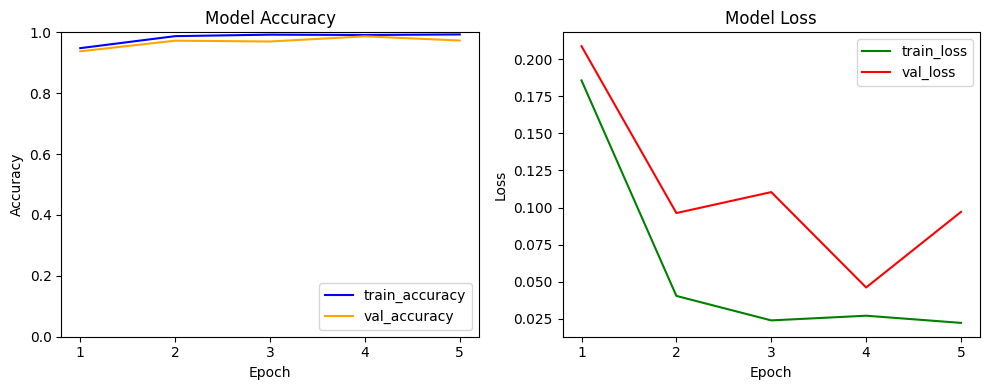

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.69%,
Test Accuracy: 93.16%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 21 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split ResNet50 model: Train only first 24 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv3_block4_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_15, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Act

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 5,679,019 (21.66 MB)

 Trainable params: 5,667,883 (21.62 MB)

 Non-trainable params: 11,136 (43.50 KB)

###Compile and train the model

Train only first 24 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - accuracy: 0.8656 - loss: 0.4888 - val_accuracy: 0.9290 - val_loss: 0.2674
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9847 - loss: 0.0528 - val_accuracy: 0.9699 - val_loss: 0.0991
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9936 - loss: 0.0224 - val_accuracy: 0.9607 - val_loss: 0.1316
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9918 - loss: 0.0269 - val_accuracy: 0.9769 - val_loss: 0.0756
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9982 - loss: 0.0078 - val_accuracy: 0.9777 - val_loss: 0.0785


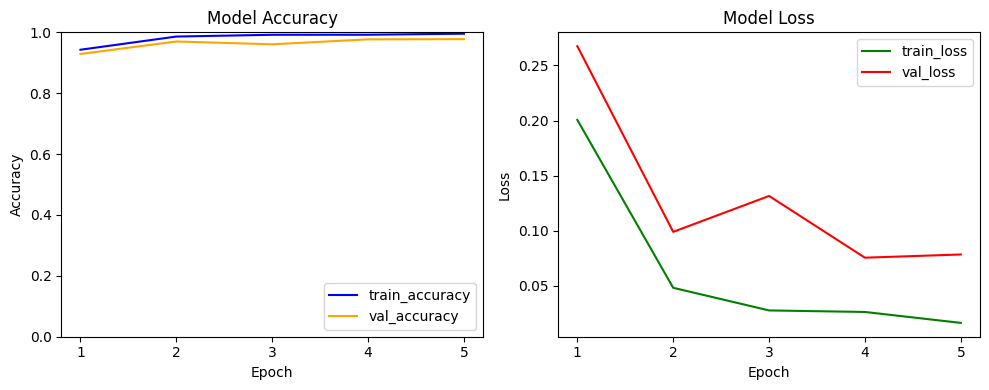

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 97.69%,
Test Accuracy: 91.41%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 24 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split ResNet50 model: Train only first 28 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv4_block1_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_16, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Act

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 5,104,043 (19.47 MB)

 Trainable params: 5,086,763 (19.40 MB)

 Non-trainable params: 17,280 (67.50 KB)

###Compile and train the model

Train only first 28 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - accuracy: 0.8363 - loss: 0.5709 - val_accuracy: 0.9180 - val_loss: 0.2788
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9811 - loss: 0.0646 - val_accuracy: 0.9504 - val_loss: 0.1753
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9853 - loss: 0.0495 - val_accuracy: 0.9667 - val_loss: 0.1147
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9883 - loss: 0.0413 - val_accuracy: 0.9818 - val_loss: 0.0620
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9905 - loss: 0.0305 - val_accuracy: 0.9672 - val_loss: 0.1213


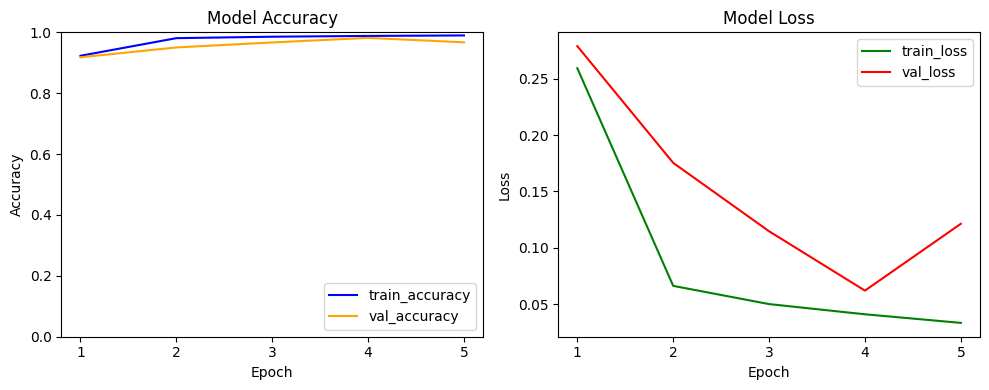

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.18%,
Test Accuracy: 92.99%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 28 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split ResNet50 model: Train only first 31 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv4_block2_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_19, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Act

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 6,225,835 (23.75 MB)

 Trainable params: 6,205,483 (23.67 MB)

 Non-trainable params: 20,352 (79.50 KB)

###Compile and train the model

Train only first 31 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.8374 - loss: 0.5748 - val_accuracy: 0.8921 - val_loss: 0.3299
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.9794 - loss: 0.0727 - val_accuracy: 0.8989 - val_loss: 0.3710
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9838 - loss: 0.0547 - val_accuracy: 0.9833 - val_loss: 0.0532
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9886 - loss: 0.0396 - val_accuracy: 0.9782 - val_loss: 0.0780
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.9923 - loss: 0.0286 - val_accuracy: 0.9592 - val_loss: 0.1462


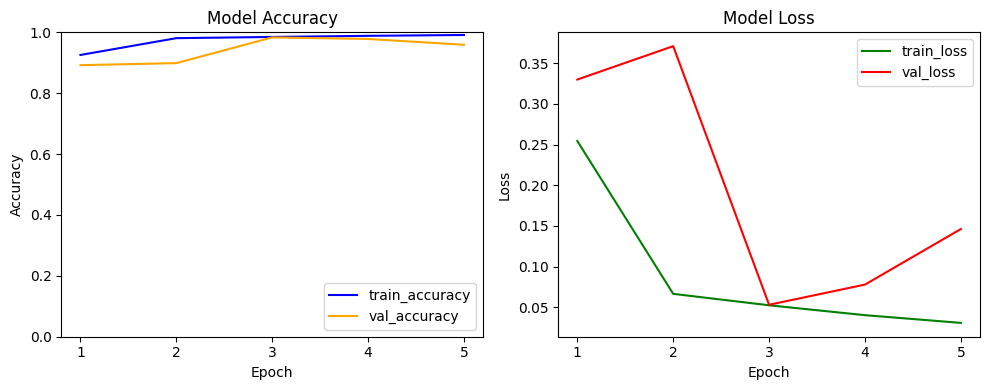

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.33%,
Test Accuracy: 93.37%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 31 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split ResNet50 model: Train only first 34 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('conv4_block3_out').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_21, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Act

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 7,347,627 (28.03 MB)

 Trainable params: 7,324,203 (27.94 MB)

 Non-trainable params: 23,424 (91.50 KB)

###Compile and train the model

Train only first 34 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.8252 - loss: 0.6232 - val_accuracy: 0.9084 - val_loss: 0.3268
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9768 - loss: 0.0796 - val_accuracy: 0.9475 - val_loss: 0.1739
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9850 - loss: 0.0502 - val_accuracy: 0.9652 - val_loss: 0.1251
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9866 - loss: 0.0479 - val_accuracy: 0.9440 - val_loss: 0.1997
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9899 - loss: 0.0360 - val_accuracy: 0.9816 - val_loss: 0.0621


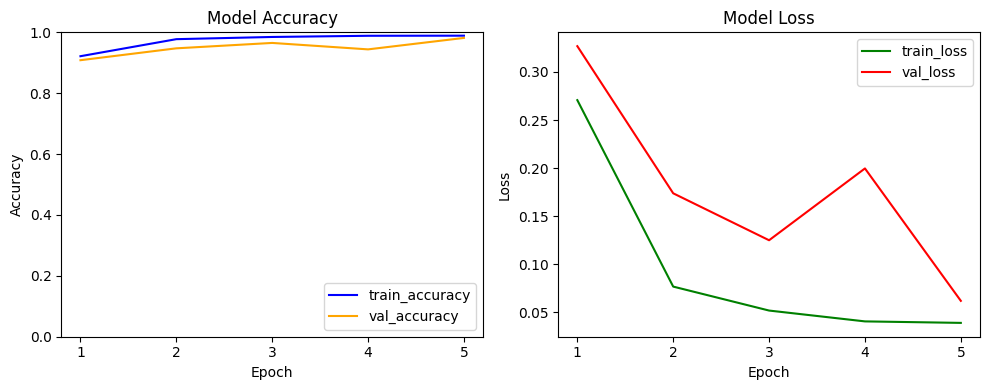

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.16%,
Test Accuracy: 93.49%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 34 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Fine Tuning (Layer experiments) Results:
Trainable base model layers: 0,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 66.25%,
Test Accuracy: 50.10%.

Trainable base model layers: Top 32,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 8.79%,
Test Accuracy: 8.45%.

Trainable base model layers: Top 94,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 9.82%,
Test Accuracy: 9.33%.

Trainable base model layers: Top 150,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 71.75%,
Test Accuracy: 68.15%.

Trainable base model layers: All,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 95.46%,
Test Accuracy: 90.85%.

##Split ResNet50 Model
Train first 1 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.09%,
Test Accuracy: 91.94%.

Train first 5 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.67%,
Test Accuracy: 93.62%.

**Train first 8 convolutional layers, Learning rate: 0.001, Batch Size: 32, Validation accuracy: 99.07%, Test Accuracy: 94.97%.**

Train first 11 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 97.92%,
Test Accuracy: 94.01%.

Train first 15 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.51%,
Test Accuracy: 94.00%.

Train first 18 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.07%,
Test Accuracy: 93.84%.

Train first 21 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.69%,
Test Accuracy: 93.16%.

Train first 24 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 97.69%,
Test Accuracy: 91.41%.

Train first 28 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.18%,
Test Accuracy: 92.99%.

Train first 31 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.33%,
Test Accuracy: 93.37%.

Train first 34 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.16%,
Test Accuracy: 93.49%.

#Part 4: Hyperparameter Tuning

In the following cell, different learning rates and batch sizes will be experimented on the model. The batch size will be set to 32 during learning rate experiments. During experiments model will be trained for 5 epochs only. Then the best models will be trained for more epochs.

##Load Model:

###Split the ResNet50 model: Train only first 8 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# write a function to load vgg16 model
def load_ResNet50_model_8_conv_layer(input_shape):

    """
    This function will load vgg16 model with its all base model layers as trainable
    It will accept input shape as parameter
    """

    # Load the VGG16 base model
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Add new layers on top of the base model
    model = Sequential()
    model.add(base_model)

    # Continue with your custom layers
    x = base_model.get_layer('conv2_block2_out').output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='sigmoid')(x)
    out = Dense(43, activation='softmax')(x)

    model = models.Model(inputs = base_model.input, outputs = out, name='model')

    return model

# Call the function
model = load_ResNet50_model_8_conv_layer((IMG_SIZE, IMG_SIZE, 3))

# Print model summary
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 8,570,411 (32.69 MB)

 Trainable params: 8,567,723 (32.68 MB)

 Non-trainable params: 2,688 (10.50 KB)

##4.1 Learning Rate (LR) Experiments

###Compile and train the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.0001, 0.00001]
BATCH_SIZE = 32
EPOCHS = 5

loop = 1

for lr in learning_rate:

    print(f'*********************************************************')
    print(f'Experiment {loop} starts')

    print(f"Train the best model: only first 8 convolution layers trainable\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_ResNet50_model_8_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Experiment {loop} finish')
    loop += 1

    print(f'*********************************************************\n\n')

*********************************************************
Experiment 1 starts
Train the best model: only first 8 convolution layers trainable
Training model with learning rate = 0.0001 and Batch Size = 32
Epoch 1/5


InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-966178b09291>", line 21, in <cell line: 10>

  File "<ipython-input-23-caaaed70f536>", line 18, in train_model

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

ptxas exited with non-zero error code 2, output: : If the error message indicates that a file could not be written, please verify that sufficient filesystem space is provided.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_198436]

## Learning Rate (LR) experiments results:
###Train first 4 convolutional layers
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.80%,
Test Accuracy: **98.11%**.

Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.89%,
Test Accuracy: **98.80%**.

Learning rate: 1e-05,
Batch Size: 32,
Validation accuracy: 99.52%,
Test Accuracy: 97.30%.

##4.2 Batch Size Experiments

Different batch sizes will be experimented on the model in the following cells with different learning rates.

###Compile and train the model

*********************************************************
Batch Size Experiment 1 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.001 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9025 - loss: 0.4024 - val_accuracy: 0.9906 - val_loss: 0.0393
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9962 - loss: 0.0159 - val_accuracy: 0.9950 - val_loss: 0.0202
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9971 - loss: 0.0112 - val_accuracy: 0.9904 - val_loss: 0.0351
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9974 - loss: 0.0093 - val_accuracy: 0.9823 - val_loss: 0.0556
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9959 - loss: 0.0136 - val_accuracy: 0.9939 - val_loss: 0.0213


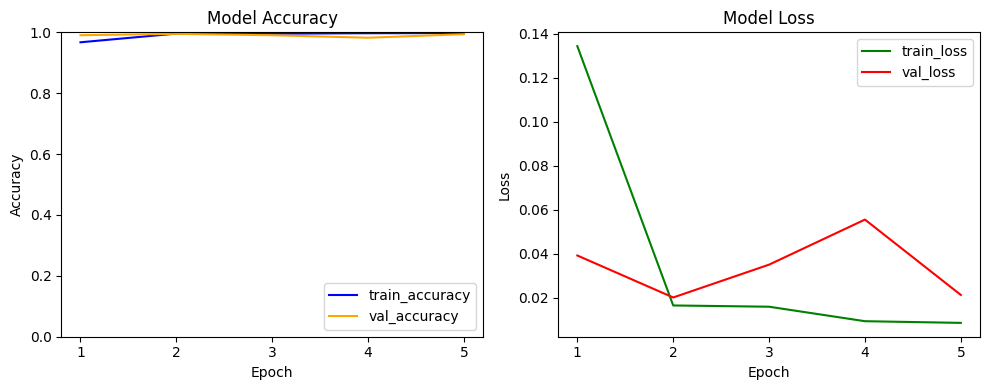

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.50%,
Test Accuracy: 96.48%.
Batch Size Experiment 1 ends
*********************************************************


*********************************************************
Batch Size Experiment 2 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.001 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.8717 - loss: 0.5252 - val_accuracy: 0.9944 - val_loss: 0.0320
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9997 - loss: 0.0047 - val_accuracy: 0.9895 - val_loss: 0.0398
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9977 - loss: 0.0117 - val_accuracy: 0.9985 - val_loss: 0.0057
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9986 - val_loss: 0.0046
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 1.0000

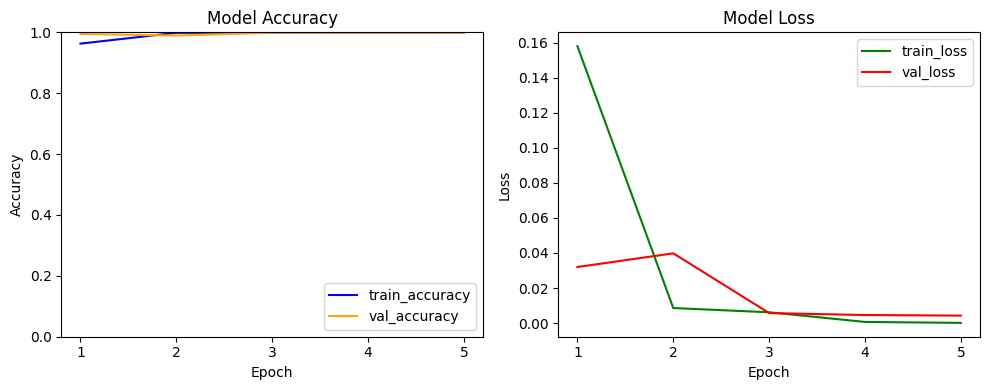

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.87%,
Test Accuracy: 98.76%.
Batch Size Experiment 2 ends
*********************************************************


*********************************************************
Batch Size Experiment 3 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.001 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8411 - loss: 0.6369 - val_accuracy: 0.9971 - val_loss: 0.0326
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9999 - loss: 0.0043 - val_accuracy: 0.9977 - val_loss: 0.0122
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9989 - val_loss: 0.0053
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 1.0000 - loss: 4.4646e-04 - val_accuracy: 0.9991 - val_loss: 0.0046
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 1.

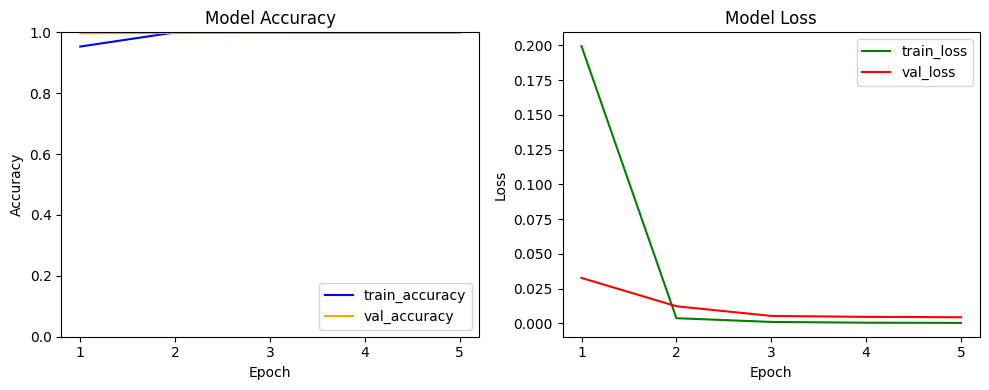

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.90%,
Test Accuracy: 98.80%.
Batch Size Experiment 3 ends
*********************************************************


*********************************************************
Batch Size Experiment 4 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.0001 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8351 - loss: 0.7581 - val_accuracy: 0.9968 - val_loss: 0.0295
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9997 - loss: 0.0137 - val_accuracy: 0.9989 - val_loss: 0.0123
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0065
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9943 - val_loss: 0.0243
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy

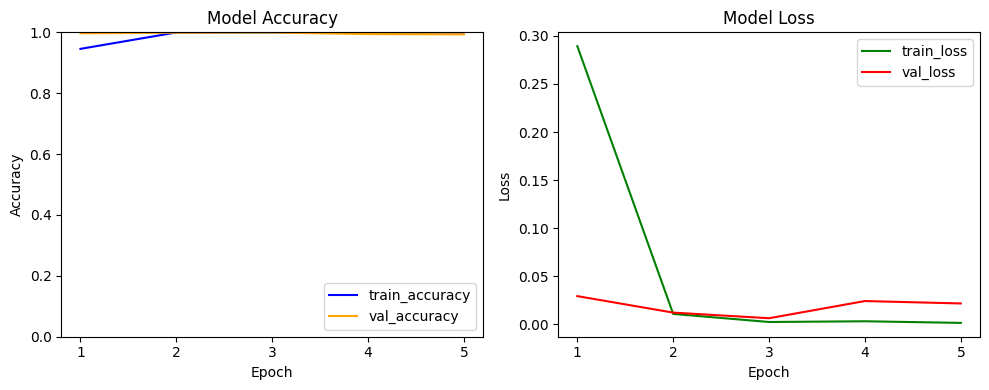

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.94%,
Test Accuracy: 98.46%.
Batch Size Experiment 4 ends
*********************************************************


*********************************************************
Batch Size Experiment 5 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.0001 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7300 - loss: 1.2319 - val_accuracy: 0.9888 - val_loss: 0.2112
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9980 - loss: 0.0519 - val_accuracy: 0.9978 - val_loss: 0.0374
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9997 - loss: 0.0163 - val_accuracy: 0.9983 - val_loss: 0.0173
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9998 - loss: 0.0077 - val_accuracy: 0.9986 - val_loss: 0.0122
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 1.000

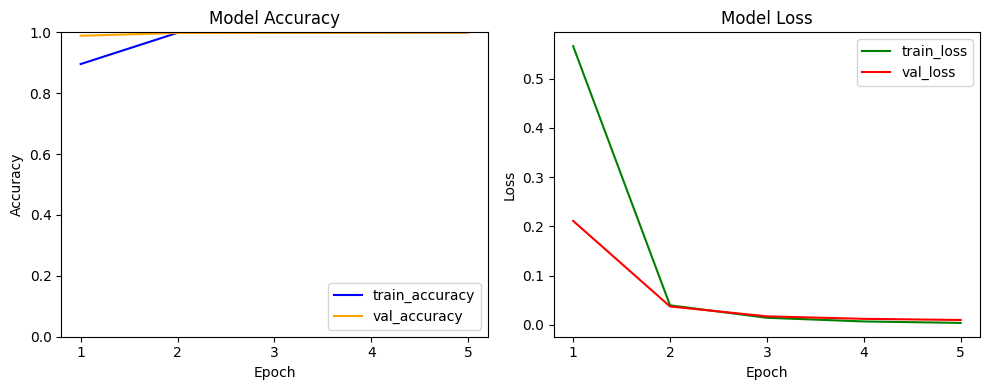

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 99.89%,
Test Accuracy: 98.73%.
Batch Size Experiment 5 ends
*********************************************************


*********************************************************
Batch Size Experiment 6 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.0001 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6339 - loss: 1.6232 - val_accuracy: 0.9740 - val_loss: 0.4150
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9933 - loss: 0.1170 - val_accuracy: 0.9963 - val_loss: 0.0922
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9993 - loss: 0.0380 - val_accuracy: 0.9982 - val_loss: 0.0401
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9999 - loss: 0.0191 - val_accuracy: 0.9987 - val_loss: 0.0223
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 1.00

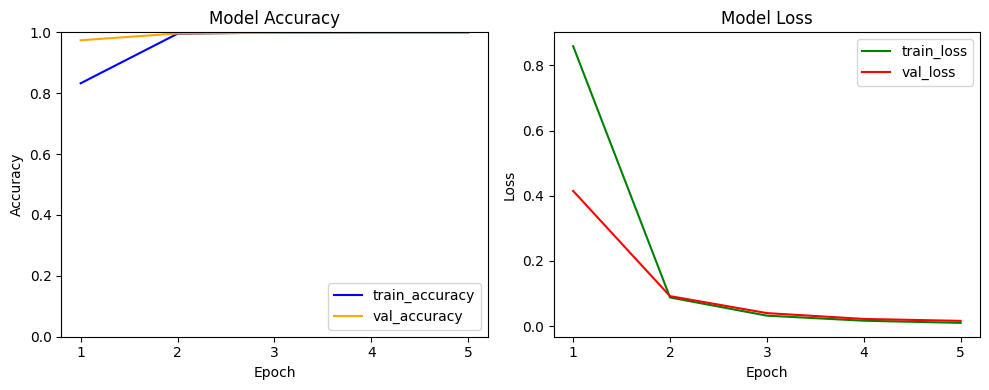

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 128,
Validation accuracy: 99.89%,
Test Accuracy: 98.49%.
Batch Size Experiment 6 ends
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.001, 0.0001]
batch_sizes = [16, 64, 128]
EPOCHS = 5

loop = 1

for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Batch Size Experiment {loop} starts')
    print(f"Train the best model: only first 8 convolution layers trainable\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_ResNet50_model_8_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Batch Size Experiment {loop} ends')
    loop += 1

    print(f'*********************************************************\n\n')

## Batch size experiments results:
###Train first 4 convolutional layers
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.50%,
Test Accuracy: 96.48%.

Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.80%,
Test Accuracy: 98.11%.

**Learning rate: 0.001, Batch Size: 64, Validation accuracy: 99.87%, Test Accuracy: 98.76%.**

**Learning rate: 0.001, Batch Size: 128, Validation accuracy: 99.90%, Test Accuracy: 98.80%.**

Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.94%,
Test Accuracy: 98.46%.

**Learning rate: 0.0001, Batch Size: 32, Validation accuracy: 99.89%, Test Accuracy: 98.80%.**

**Learning rate: 0.0001, Batch Size: 64, Validation accuracy: 99.89%, Test Accuracy: 98.73%.**

Learning rate: 0.0001,
Batch Size: 128,
Validation accuracy: 99.89%,
Test Accuracy: 98.49%.

**In the next step, 4 best models will be trained for more epochs.**

#Part 5: Training the best models for more epochs

##Compile and train the model

##Learning rate 0.001

*********************************************************
Training the best models for more epochs
Model 1 training starts
Trainable base model layers: All
Learning rate = 0.001 and Batch Size = 64
Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8766 - loss: 0.5030 - val_accuracy: 0.9769 - val_loss: 0.0850
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9982 - loss: 0.0116 - val_accuracy: 0.9967 - val_loss: 0.0183
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9986 - loss: 0.0064 - val_accuracy: 0.9865 - val_loss: 0.0553
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9970 - loss: 0.0101 - val_accuracy: 0.9982 - val_loss: 0.0079
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 2.3946e-04 - val_accuracy: 0.9985 - val_loss: 0.0058
Epoch 6/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 1.0000 - loss: 9.2893e-05 - val_accuracy: 0.9986 - val_loss: 0.0056
Epoch 7/50
490/490

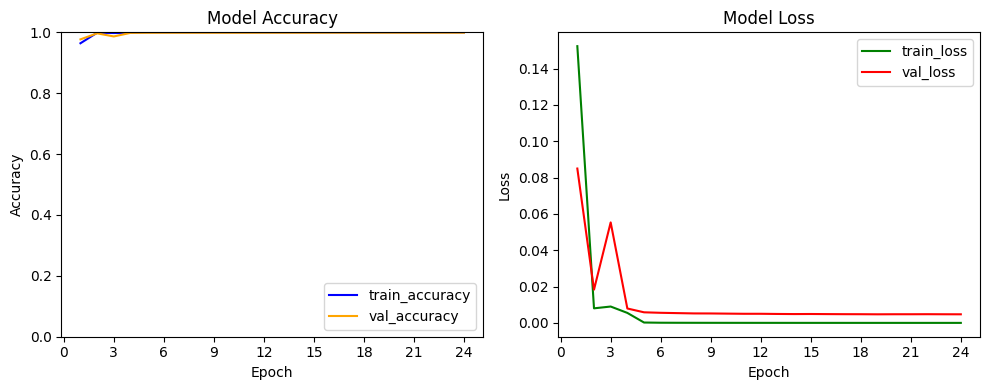

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.89%,
Test Accuracy: 98.66%.
Model 1 ends
*********************************************************


*********************************************************
Training the best models for more epochs
Model 2 training starts
Trainable base model layers: All
Learning rate = 0.001 and Batch Size = 128
Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8339 - loss: 0.6773 - val_accuracy: 0.9962 - val_loss: 0.0308
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9992 - loss: 0.0065 - val_accuracy: 0.9987 - val_loss: 0.0122
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9991 - val_loss: 0.0049
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 1.0000 - loss: 5.7118e-04 - val_accuracy: 0.9990 - val_loss: 0.0045
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 1.0000 - l

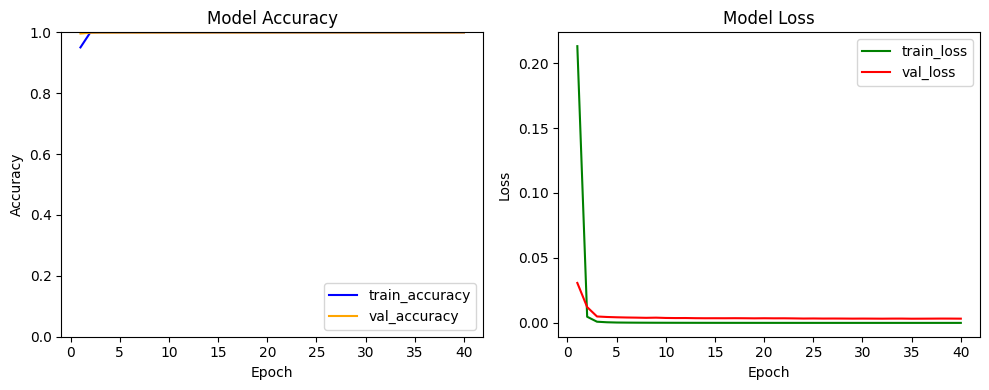

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.94%,
Test Accuracy: 98.98%.
Model 2 ends
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.001]
batch_sizes = [64, 128]
EPOCHS = 50

model_counter = 1
for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Training the best models for more epochs')
    print(f'Model {model_counter} training starts')
    print(f"Trainable base model layers: All\nLearning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Model {model_counter} ends')
    model_counter += 1

    print(f'*********************************************************\n\n')

##Compile and train the model

##Learning rate 0.0001

*********************************************************
Training the best models for more epochs
Model 1 training starts
Trainable base model layers: All
Learning rate = 0.0001 and Batch Size = 32
Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7946 - loss: 0.9604 - val_accuracy: 0.9963 - val_loss: 0.0595
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9991 - loss: 0.0262 - val_accuracy: 0.9982 - val_loss: 0.0195
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9990 - val_loss: 0.0100
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9987 - val_loss: 0.0072
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9987 - val_loss: 0.0077
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0050
Epoch 7/50
980/980 ━━━━━━━━━━━

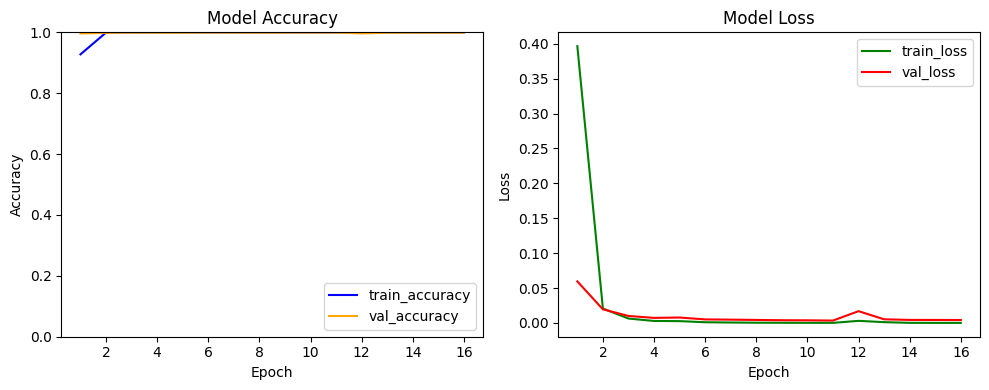

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.92%,
Test Accuracy: 98.93%.
Model 1 ends
*********************************************************


*********************************************************
Training the best models for more epochs
Model 2 training starts
Trainable base model layers: All
Learning rate = 0.0001 and Batch Size = 64
Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7261 - loss: 1.2393 - val_accuracy: 0.9932 - val_loss: 0.1686
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9974 - loss: 0.0544 - val_accuracy: 0.9976 - val_loss: 0.0358
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9996 - loss: 0.0176 - val_accuracy: 0.9983 - val_loss: 0.0204
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9987 - val_loss: 0.0140
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 1.0000 - loss

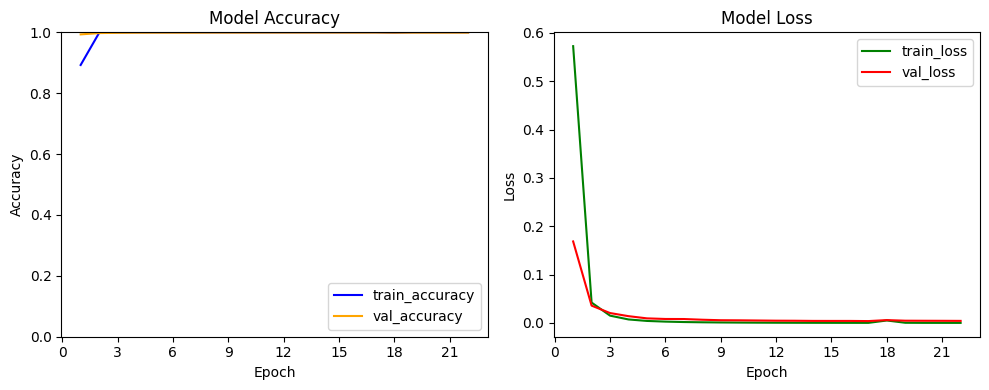

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 99.92%,
Test Accuracy: 98.92%.
Model 2 ends
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.0001]
batch_sizes = [32, 64]
EPOCHS = 50

model_counter = 1
for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Training the best models for more epochs')
    print(f'Model {model_counter} training starts')
    print(f"Trainable base model layers: All\nLearning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Model {model_counter} ends')
    model_counter += 1

    print(f'*********************************************************\n\n')

##Best models with more epochs results:
###Train first 4 convolutional layers
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.89%,
Test Accuracy: 98.66%.

**Learning rate: 0.001, Batch Size: 128, Validation accuracy: 99.94%, Test Accuracy: 98.98%.**

Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.92%,
Test Accuracy: 98.93%.

Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 99.92%,
Test Accuracy: 98.92%.

#Part 6: Synthetic Minority Oversampling Technique (SMOTE)

Applying Synthetic Minority Oversampling Technique (SMOTE) to over-sample the classes which are under-represented. This helps balance the dataset and improve the performance of machine learning models, particularly for imbalanced classification tasks.

In [ ]:
train_images, train_labels = images, labels

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

train_rows=len(train_images)
train_images = train_images.reshape(train_rows,-1)

train_images, train_labels = sm.fit_resample(train_images, train_labels)
train_images = train_images.reshape(-1,32,32,3)

print(f'Total number of train images and labels after applying SMOTE')
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')

Total number of train images and labels after applying SMOTE
Train images shape: (96750, 32, 32, 3)
Train labels shape: (96750, 43)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 70% of the dataset will be used for training, and the remaining 30% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (77400, 32, 32, 3)
Validation data shape: (19350, 32, 32, 3)


##Compile and train the model

*********************************************************
Training the best model on oversampled dataset
Train using only first 4 convolution layers
Learning rate = 0.001 and Batch Size = 128
Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9154 - loss: 0.3578 - val_accuracy: 0.9980 - val_loss: 0.0109
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9996 - loss: 0.0029 - val_accuracy: 0.9983 - val_loss: 0.0121
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9976 - val_loss: 0.0108
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9988 - val_loss: 0.0045
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9989 - val_loss: 0.0042
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9999 - loss: 4.6712e-04 - val_accuracy: 0.9973 - val_loss: 0.0137
Epoch 7/50
604/604 ━━━━━

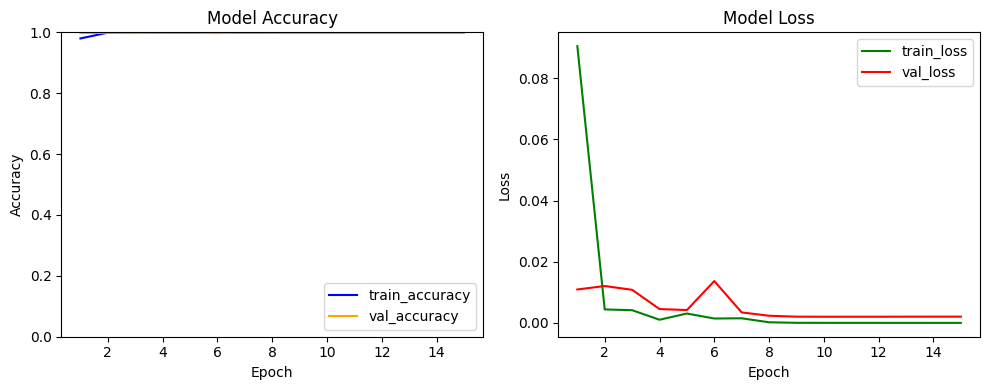

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.95%,
Test Accuracy: 98.60%.
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

batch_sizes = [128]
learning_rate = [0.001]
EPOCHS = 50

for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Training the best model on oversampled dataset')
    print(f"Train using only first 4 convolution layers\nLearning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'*********************************************************\n\n')

##Best model on oversampled dataset results:
###Train first 4 convolutional layers
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.95%,
Test Accuracy: 98.60%.


#Conclusion
**Best model:**<br>
Train first 4 convolutional layers of vgg16 model along with top layers.<br>
**parameters:** <br>
Learning rate: 0.001<br>
Batch size: 128<br>
**Best Accuracy:** **98.98%**.

